In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf


def tratar_outliers_multimetodos(data, method="winsor", **kwargs):

    if isinstance(data, pd.Series):
        df = pd.DataFrame({"col": data})
    else:
        df = data.copy()

    df_out = pd.DataFrame(index=df.index)

    for col in df.columns:
        s = df[col].copy()

        if method == "winsor":
            limits = kwargs.get("limits", (0.01, 0.99))
            df_out[col] = winsorize(s, limits=(limits[0], 1 - limits[1]))

        elif method == "iqr":
            factor = kwargs.get("factor", 1.5)
            Q1 = s.quantile(0.25)
            Q3 = s.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            s = s.astype(float)
            s[s < lower] = lower
            s[s > upper] = upper
            df_out[col] = s.values

        elif method == "zscore":
            threshold = kwargs.get("threshold", 3)
            s_z = zscore(s, nan_policy='omit')
            s[(s_z > threshold) | (s_z < -threshold)] = np.nan
            df_out[col] = s.interpolate().ffill().bfill().values

        elif method == "isolation_forest":
            contamination = kwargs.get("contamination", 0.01)
            random_state = kwargs.get("random_state", 42)
            iso = IsolationForest(contamination=contamination, random_state=random_state)
            mask = iso.fit_predict(s.values.reshape(-1,1))
            s[mask == -1] = np.nan
            df_out[col] = s.interpolate().bfill().values

        else:
            raise ValueError(f"Método '{method}' não suportado.")

    # Retornar Series se input foi Series
    if isinstance(data, pd.Series):
        return df_out["col"]
    else:
        return df_out


def cria_atributos_defasados(y, n_lags=4, dropna=True):

    y = pd.Series(y).reset_index(drop=True)
    data = {f"lag_{i}": y.shift(i) for i in range(1, n_lags + 1)}
    X = pd.DataFrame(data)
    y_target = y.copy()  # valor atual
    if dropna:
        valid_idx = X.dropna().index
        X = X.loc[valid_idx].reset_index(drop=True)
        y_target = y_target.loc[valid_idx].reset_index(drop=True)
    return X, y_target

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def cv_serie_temporal(
    X, y, model,
    window_size=2*24*7,  # 2 semanas de dados
    horizon=2,
    n_splits=10,
    metric="rmse", # "mae", "mse", "rmse", "mape", "r2"
    scale_method=None, # None, "standard", "minmax"
    outlier_method="winsor", # "winsor", "iqr", "zscore", "isolation_forest"
    outlier_params=None # parâmetros do método de outlier
):
    """
    Validação cruzada para séries temporais com tratamento flexível de outliers e escalonamento.
    """

    # --- Métricas ---
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        nonzero_mask = y_true != 0
        return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

    metrics_dict = {
        "mae": mean_absolute_error,
        "mse": mean_squared_error,
        "rmse": rmse,
        "mape": mape,
        "r2": r2_score
    }

    if metric not in metrics_dict:
        raise ValueError(f"Métrica '{metric}' não suportada. Escolha entre {list(metrics_dict.keys())}.")

    score_fn = metrics_dict[metric]
    scores = []

    if outlier_params is None:
        outlier_params = {}

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if len(train_idx) < window_size + horizon:
            continue

        train_end = train_idx[-1]
        X_train = X[train_end - window_size + 1 : train_end + 1].copy()
        y_train = y[train_end - window_size + 1 : train_end + 1].copy()
        X_test = X[train_end + 1 : train_end + 1 + horizon].copy()
        y_test = y[train_end + 1 : train_end + 1 + horizon].copy()

        # --- Tratamento de outliers em todos os atributos ---
        if outlier_method is not None:
            # Para DataFrame ou array 2D
            if isinstance(X_train, pd.DataFrame):
                X_train = pd.DataFrame({col: tratar_outliers_multimetodos(X_train[col], method=outlier_method, **outlier_params)
                                        for col in X_train.columns})
                X_test = pd.DataFrame({col: tratar_outliers_multimetodos(X_test[col], method=outlier_method, **outlier_params)
                                       for col in X_test.columns})
            else:
                # numpy array
                X_train = np.column_stack([tratar_outliers_multimetodos(X_train[:, i], method=outlier_method, **outlier_params)
                                           for i in range(X_train.shape[1])])
                X_test = np.column_stack([tratar_outliers_multimetodos(X_test[:, i], method=outlier_method, **outlier_params)
                                          for i in range(X_test.shape[1])])

            # Target
            y_train = tratar_outliers_multimetodos(y_train, method=outlier_method, **outlier_params)
            y_test = tratar_outliers_multimetodos(y_test, method=outlier_method, **outlier_params)

        # --- Escalonamento ---
        if scale_method is not None:
            if scale_method == "standard":
                scaler_X, scaler_y = StandardScaler(), StandardScaler()
            elif scale_method == "minmax":
                scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
            else:
                raise ValueError("scale_method deve ser 'standard', 'minmax' ou None.")

            X_train, X_test = X_train.values, X_test.values
            y_train, y_test = y_train.values, y_test.values
            X_train = scaler_X.fit_transform(X_train)
            y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
            X_test = scaler_X.transform(X_test)
            y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

            model.fit(X_train, y_train)
            y_pred_scaled = model.predict(X_test)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # --- Avaliação ---
        score = score_fn(y_test, y_pred)
        scores.append(score)
        print(f"Fold {fold+1} | {metric.upper()}: {score:.4f}")

    print(f"\nMédia {metric.upper()} = {np.mean(scores):.4f}")
    return {"scores": scores, "mean_score": np.mean(scores)}


In [2]:
df = pd.read_csv('/content/drive/MyDrive/ProbEstatistica/1_ano_dados_data_center_limpa.csv')
df.set_index(df["timestamp"], inplace=True)
df.drop(columns=["timestamp"],inplace=True)
df.index = pd.to_datetime(df.index)

In [3]:
# Pegando 80% dos dados do início ao fim
df_requisicoes_treino = df.requisicoes[:int(df.requisicoes.shape[0]*0.8)]

# Pegando 20% dos dados restantes para o nosso conjunto de teste
df_requisicoes_teste = df.requisicoes[:int(df.requisicoes.shape[0]*0.8):]

X, y = cria_atributos_defasados(df_requisicoes_treino, n_lags=4)

scores = cv_serie_temporal(
            X=X,
            y=y,
            model=LinearRegression(),
            window_size=24*7*2,
            horizon=10,
            n_splits=10,
            metric="mape",
            scale_method="standard", # "standard" ou "minmax"
            outlier_method="isolation_forest" # "winsor" "iqr" "zscore" "isolation_forest"
        )

Fold 1 | MAPE: 20.4120
Fold 2 | MAPE: 16.6833
Fold 3 | MAPE: 10.4055
Fold 4 | MAPE: 28.2871
Fold 5 | MAPE: 26.0578
Fold 6 | MAPE: 40.5791
Fold 7 | MAPE: 21.6452
Fold 8 | MAPE: 16.2102
Fold 9 | MAPE: 29.9406
Fold 10 | MAPE: 35.8687

Média MAPE = 24.6089


In [16]:
import pandas as pd
import numpy as np
import time
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed


def avaliar_modelos_temporais(df, n_lags=4, n_splits=3, n_jobs=-1):
    """
    Avalia modelos de ML e modelos estatísticos (ARIMA/SARIMA/SARIMAX)
    com validação temporal e retorna MAPE + tempo médio de execução.
    """

    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # === Features temporais ===
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['mes'] = df.index.month
    feriados_br = holidays.Brazil()
    df['feriado'] = df.index.map(lambda x: 1 if x in feriados_br else 0)

    # === Lags ===
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['requisicoes'].shift(i)

    df = df.dropna()

    X = df.drop(columns='requisicoes')
    y = df['requisicoes']

    # === Padronização das features ===
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=X.columns
    )

    # === Modelos ===
    modelos_ml = {
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, n_estimators=200, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, n_estimators=200)
    }

    modelos_est = {
        'ARIMA': (ARIMA, {'order': (2, 1, 2)}),
        'SARIMA': (SARIMAX, {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 24)}),
        'SARIMAX': (SARIMAX, {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 24)})
    }

    def avaliar_modelo(nome, modelo, X, y, inicio_teste, fim_teste):
        X_treino = X.iloc[:inicio_teste]
        y_treino = y.iloc[:inicio_teste]
        X_teste = X.iloc[inicio_teste:fim_teste]
        y_teste = y.iloc[inicio_teste:fim_teste]

        if len(X_treino) == 0:
            return None

        inicio = time.time()

        # --- Modelos estatísticos ---
        if nome in modelos_est:
            cls, params = modelo
            if nome == 'SARIMAX':
                mod = cls(y_treino, exog=X_treino[['hora', 'dia_semana', 'mes', 'feriado']], **params)
                res = mod.fit(disp=False)
                y_pred = res.predict(
                    start=y_teste.index[0],
                    end=y_teste.index[-1],
                    exog=X_teste[['hora', 'dia_semana', 'mes', 'feriado']]
                )
            else:
                mod = cls(y_treino, **params)
                res = mod.fit()
                y_pred = res.predict(start=y_teste.index[0], end=y_teste.index[-1])
        else:
            # --- Modelos de ML ---
            modelo.fit(X_treino, y_treino)
            y_pred = modelo.predict(X_teste)

        fim = time.time()
        mape = mean_absolute_percentage_error(y_teste, y_pred)
        tempo = fim - inicio

        return nome, mape, tempo

    # === Validação temporal ===
    tamanho = len(df)
    tamanho_fold = tamanho // n_splits
    resultados = {}
    tempos = {}

    for nome in list(modelos_ml.keys()) + list(modelos_est.keys()):
        resultados[nome] = []
        tempos[nome] = []

    for i in range(n_splits):
        inicio_teste = i * tamanho_fold
        fim_teste = (i + 1) * tamanho_fold if i < n_splits - 1 else tamanho

        avaliacoes = Parallel(n_jobs=n_jobs)(
            delayed(avaliar_modelo)(nome, modelo,
                                    X_scaled if nome in modelos_ml else X,
                                    y, inicio_teste, fim_teste)
            for nome, modelo in {**modelos_ml, **modelos_est}.items()
        )

        for res in avaliacoes:
            if res is None:
                continue
            nome, mape, tempo = res
            resultados[nome].append(mape)
            tempos[nome].append(tempo)

    # === MAPE médio e tempo médio ===
    medias = {nome: np.mean(mapes) for nome, mapes in resultados.items() if len(mapes) > 0}
    tempos_medios = {nome: np.mean(ts) for nome, ts in tempos.items() if len(ts) > 0}

    return pd.DataFrame({
        'MAPE_medio': medias,
        'Tempo_medio_s': tempos_medios
    }).sort_values('MAPE_medio')



In [17]:
resultados = avaliar_modelos_temporais(df[['requisicoes']])
print(resultados)

                  MAPE_medio  Tempo_medio_s
LightGBM            0.161173       0.387088
XGBoost             0.173590       0.648286
DecisionTree        0.215151       0.131922
LinearRegression    0.276763       0.009177
ARIMA               0.406490       7.664765
SARIMA              0.489950      97.897158
SARIMAX             0.832718     131.709028


/tmp/ipython-input-2530159392.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(modelos, rotation=45, ha='right')


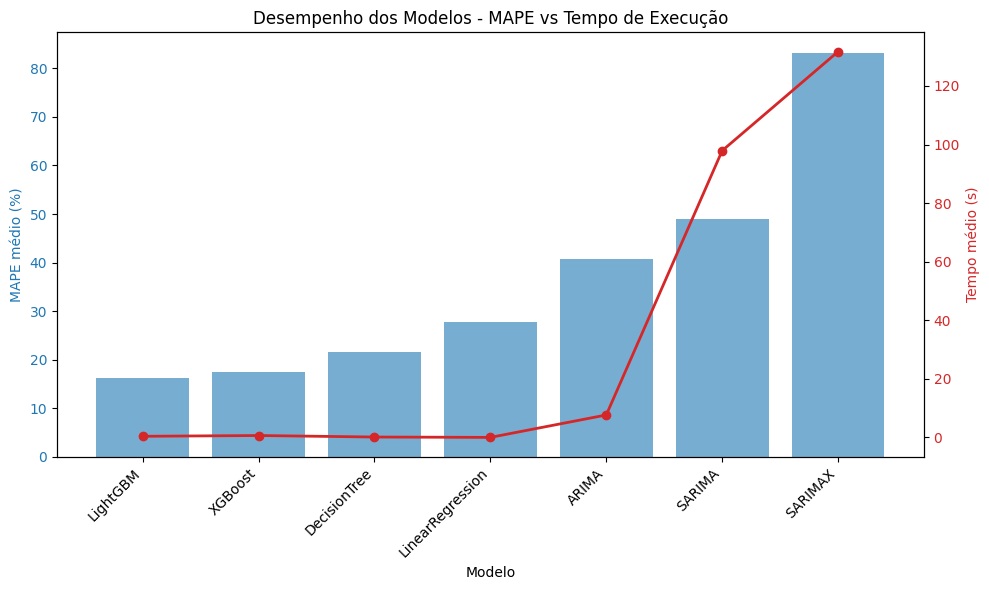

In [18]:
import matplotlib.pyplot as plt

def plotar_resultados(df_resultados):
    """
    Plota MAPE médio e tempo médio de execução para cada modelo em dois eixos Y.

    Parâmetros:
    - df_resultados: DataFrame retornado pela função avaliar_modelos_temporais
    """

    fig, ax1 = plt.subplots(figsize=(10, 6))

    modelos = df_resultados.index
    mape = df_resultados['MAPE_medio']
    tempo = df_resultados['Tempo_medio_s']

    # Eixo 1 - MAPE
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('MAPE médio (%)', color='tab:blue')
    ax1.bar(modelos, mape * 100, color='tab:blue', alpha=0.6, label='MAPE (%)')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticklabels(modelos, rotation=45, ha='right')

    # Eixo 2 - Tempo
    ax2 = ax1.twinx()
    ax2.set_ylabel('Tempo médio (s)', color='tab:red')
    ax2.plot(modelos, tempo, color='tab:red', marker='o', linewidth=2, label='Tempo (s)')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Título e layout
    plt.title('Desempenho dos Modelos - MAPE vs Tempo de Execução')
    fig.tight_layout()
    plt.show()

plotar_resultados(resultados)